# JEPA Validation

This notebook verifies the trained JEPA model against 5 key criteria:

1. Representation Quality
2. Dynamics Prediction Accuracy
3. Physical Consistency
4. Stability (Multi-step Rollout)
5. VicReg Health Check


In [3]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import pickle
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split

# Add src to path
sys.path.append(os.path.abspath("../src"))

from rlo.policies.jepa import JEPAModule
from rlo.trainers.jepa_trainer import JEPALightningModule

%matplotlib inline

## Setup & Data Preparation


In [5]:
TRANSITIONS_PATH = "../runs/linear_random_walk/transitions-10141.pkl"

# Load Transitions
with open(TRANSITIONS_PATH, "rb") as f:
    data = pickle.load(f)
    if isinstance(data, dict) and "transitions" in data:
        transitions = data["transitions"]
    else:
        transitions = data # Assume list if not dict wrapper

print(f"Loaded {len(transitions)} transitions")

# Select Validation Set
val_transitions = transitions[:10240]
del transitions
print(f"Validation Set Size: {len(val_transitions)}")

# Extract Features
X = np.stack([t["obs"] for t in val_transitions])
A = np.array([t["action"] for t in val_transitions])
X_next = np.stack([t["next_obs"] for t in val_transitions])

feature_names = ["Energy", "X_Pos", "Can_Eat", "Near_Food"]

# Raw Data (Using same values for now as codebase implies they ARE the state)
X_raw = X.copy()
X_next_raw = X_next.copy()

# Split Indices for Baselines (80% Train, 20% Test for approx 2048)
# Shuffling is important because otherwise you'd get temporal correlations
train_idx, test_idx = train_test_split(np.arange(len(X)), test_size=0.2, random_state=42, shuffle=True)
print(f"Train size: {len(train_idx)}, Test size: {len(test_idx)}")

Loaded 166819 transitions
Validation Set Size: 10240
Train size: 8192, Test size: 2048


In [4]:
# Initialize ParamReader and set overrides
from pathlib import Path
from rlo.params import ParamReader

CHECKPOINT_PATH = "../runs/linear_random_walk/jepa-epoch=20-val_loss=0.1775.ckpt"
PARAMETERS_PATH = "../runs/linear_random_walk/params.yaml"

reader = ParamReader.get_instance()

# Load default params if available
default_params = Path(PARAMETERS_PATH)
if default_params.exists():
    reader.load(str(default_params))

# Load Model
model = JEPALightningModule.load_from_checkpoint(CHECKPOINT_PATH)
model.eval()
model.freeze()
jepa = model.jepa

print("Model Loaded")

Model Loaded


## Step 1: Latent Memory / Information Retention


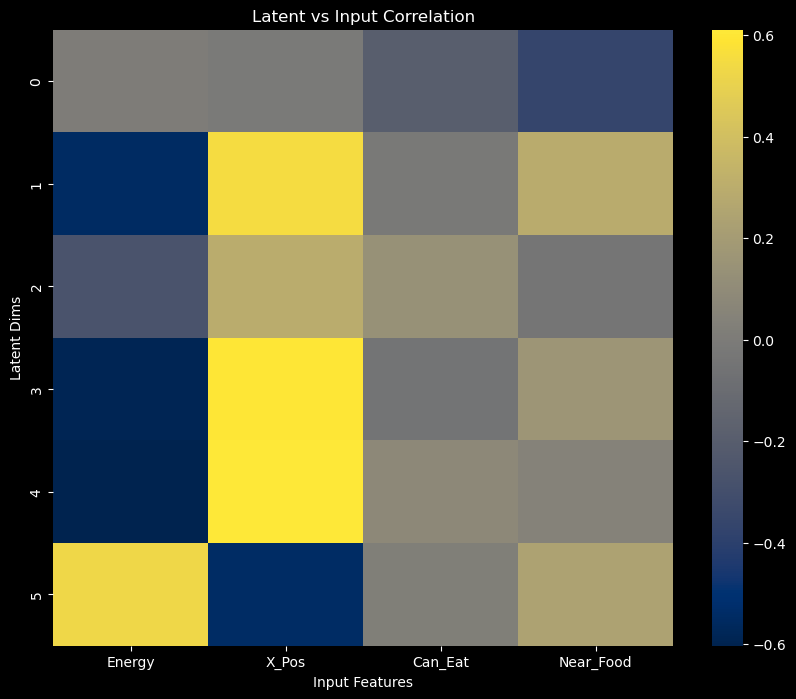


Running Linear Probes...
Energy: Ridge R2 = 0.5660
Energy: Poly R2 = 0.7335
X_Pos: Ridge R2 = 0.5949
X_Pos: Poly R2 = 0.8209
Can_Eat: Accuracy = 0.9893
Near_Food: Accuracy = 0.7910


In [7]:
from sympy import Poly
from sklearn.preprocessing import PolynomialFeatures


with torch.no_grad():
    Z = jepa.encode(torch.from_numpy(X).cuda()).cpu().numpy()

# Compute the Pearson correlation between Z and X to measure linear alignment
corr_matrix = np.zeros((Z.shape[1], X.shape[1]))
for i in range(Z.shape[1]):
    for j in range(X.shape[1]):
        corr_matrix[i, j] = np.corrcoef(Z[:, i], X[:, j])[0, 1]

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap="cividis", center=0)
plt.xlabel("Input Features")
plt.ylabel("Latent Dims")
plt.title("Latent vs Input Correlation")
plt.xticks(ticks=np.arange(4)+0.5, labels=feature_names)
plt.show()

# 1.2 Linear Probes (Ridge) - can we recover it linearly? 
print("\nRunning Linear Probes...")
results = {}
Z_train = Z[train_idx]
Z_test = Z[test_idx]
X_train = X[train_idx]
X_test = X[test_idx]

for i, name in enumerate(feature_names):
    # Train Ridge (linear regression with L2 regularization)
    ridge = Ridge(alpha=1.0)
    ridge.fit(Z_train, X_train[:, i])
    preds = ridge.predict(Z_test)

    # Use Ridge with expanded polynomial features
    poly = PolynomialFeatures(degree=2, include_bias=True)
    ridge_poly = Ridge(alpha=1.0)
    Z_poly_train = poly.fit_transform(Z_train)
    Z_poly_test = poly.transform(Z_test)
    ridge_poly.fit(Z_poly_train, X_train[:, i])
    poly_preds = ridge_poly.predict(Z_poly_test)
    
    if "Can_Eat" in name or "Near_Food" in name:
        # Binary Classification checks
        # pass a threshold of 0.5 to convert to binary predictions
        acc = accuracy_score(X_test[:, i] > 0.5, preds > 0.5)
        print(f"{name}: Accuracy = {acc:.4f}")
    else:
        # Use r2 to measure how well the ridge fits the data
        # High r2 means the latent space encodes the feature clearly and linearly
        r2 = r2_score(X_test[:, i], preds)
        print(f"{name}: Ridge R2 = {r2:.4f}")

        r2_poly = r2_score(X_test[:, i], poly_preds)
        print(f"{name}: Poly R2 = {r2_poly:.4f}")


**My Interpretations:**

- `energy` shows strong movement across the latent dim so the information is retained - How the model encoded `energy` is nonlinear because of the low value, this is proven when expanding to polynomial space
- `x_pos` is the same as `energy`
- `can_eat` and `near_food` are more spread across latent dims but are linearly recovered so there is a clear decision boundary in the internal geometry

**Verdict:** JEPA is retaining all the features and is modeling them correctly. This means there's no collapse and there's a meaningful internal geometry.


## Step 2: Dynamics & Prediction Accuracy


In [11]:
# Helpers
def train_simple(model, X, A, Y, epochs=25, batch=64):
    model = model.cuda()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    idx = np.arange(len(X))

    for _ in range(epochs):
        np.random.shuffle(idx)
        for i in range(0, len(idx), batch):
            b = idx[i:i+batch]
            bx = torch.from_numpy(X[b]).cuda()
            ba = torch.from_numpy(A[b]).cuda()
            by = torch.from_numpy(Y[b]).cuda()

            loss = F.mse_loss(model(bx, ba), by)
            opt.zero_grad()
            loss.backward()
            opt.step()

    return model

def get_action_one_hot(actions, n_cat=3):
    res = np.zeros((len(actions), n_cat), dtype=np.float32)
    res[np.arange(len(actions)), actions] = 1.0
    return res

A_train_oh = get_action_one_hot(A[train_idx])
A_test_oh = get_action_one_hot(A[test_idx])

# 1. Do Nothing Baseline - Identity: X -> X_next
pred_identity = X_test.copy()

# 2. The Oracle Baseline: (Input, Action) -> Next Input
class OracleMLP(nn.Module):
    def __init__(self, input_dim, act_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + act_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )
    def forward(self, x, a):
        return self.net(torch.cat([x, a], dim=-1))

oracle = OracleMLP(4, 3)
oracle = train_simple(oracle, X_train, A_train_oh, X_next[train_idx])

with torch.no_grad():
    pred_oracle = oracle(torch.from_numpy(X_test).cuda(), torch.from_numpy(A_test_oh).cuda()).cpu().numpy()

# 3. Frozen Encoder: (Latent, Action) -> Next Input (not next latent!)
class FrozenMLP(nn.Module):
    def __init__(self, latent_dim, act_dim, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim + act_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )
    def forward(self, z, a):
        return self.net(torch.cat([z, a], dim=-1))

frozen = FrozenMLP(jepa.latent_dim, 3, 4)
frozen = train_simple(frozen, Z_train, A_train_oh, X_next[train_idx])

with torch.no_grad():
    pred_frozen = frozen(torch.from_numpy(Z_test).cuda(), torch.from_numpy(A_test_oh).cuda()).cpu().numpy()

# 4. JEPA Model: X -> Z, (Z, A) -> Z_pred, Z_pred -> X_pred
with torch.no_grad():
    z_pred_next = jepa.transition_head(torch.cat([torch.from_numpy(Z_test).cuda(), torch.from_numpy(A_test_oh).cuda()], dim=-1))
    pred_jepa = jepa.decoder(z_pred_next).cpu().numpy()

# Compute Metrics
print(f"{('Feature'):<12} | {('Identity'):<12} | {('Oracle'):<12} | {('Frozen'):<12} | {('JEPA'):<12}")
print("-" * 65)
for i, feat in enumerate(feature_names):
    mse_id = mean_squared_error(X_next[test_idx][:, i], pred_identity[:, i])
    mse_or = mean_squared_error(X_next[test_idx][:, i], pred_oracle[:, i])
    mse_fr = mean_squared_error(X_next[test_idx][:, i], pred_frozen[:, i])
    mse_je = mean_squared_error(X_next[test_idx][:, i], pred_jepa[:, i])
    
    print(f"{feat:<12} | {mse_id:.4f} | {mse_or:.4f} | {mse_fr:.4f} | {mse_je:.4f}")

Feature      | Identity     | Oracle       | Frozen       | JEPA        
-----------------------------------------------------------------
Energy       | 0.0000 | 0.0001 | 0.0149 | 0.5704
X_Pos        | 0.0008 | 0.0000 | 97.6893 | 1140.8027
Can_Eat      | 0.0054 | 0.0051 | 0.0099 | 0.0758
Near_Food    | 0.0044 | 0.0042 | 0.1126 | 0.3627


**My Interpretations:**

- Oracle is better than identity for `x_pos` and close for the other features so that means the Oracle had learnt the dynamics
- Frozen (JEPA Encoder) is really bad for `x_pos` so the encoder did not retain it even though Pearson correlation and probe seemed to show it was
- JEPA is bad across everything which points to a bad decoder

**Verdict:** JEPA model is useless because the transition head (Z,A) is not learning to correctly predict the next state because it's not retaining `x_pos`, and on top of that it can't convert back to feature space


In [12]:
# Check the JEPA encoder to see what it's error is

# JEPA Encoder: X_next -> Z_next
with torch.no_grad():
    z_next = jepa.encode(torch.from_numpy(X_next[test_idx]).cuda())

mse_lt = F.mse_loss(
    z_pred_next,
    z_next
)

print (f"mse jepa encoder {mse_lt}")

mse jepa encoder 0.003022335469722748


**My Interpretations:**

- This shows that internally the encoder + transition head work well together to predict the next latent so they are aligned well.

**Verdict**: Decoder isn't doing a good job (that's OK), but the encoder needs to be fixed


## Step 3: Action Table


In [17]:
# Using original ALL set
df = pd.DataFrame(X_raw, columns=feature_names)
df["Action"] = A

# Recalculate JEPA on all X
with torch.no_grad():
    z_all = jepa.encode(torch.from_numpy(X).cuda())
    a_all_oh = get_action_one_hot(A)
    z_next_pred = jepa.transition_head(torch.cat([z_all, torch.from_numpy(a_all_oh).cuda()], dim=-1))
    x_next_pred = jepa.decoder(z_next_pred).cpu().numpy()

# Ground Truth vs Model
df["X_Pos_Delta_GT"] = X_next_raw[:, 1] - X_raw[:, 1]
df["X_Pos_Delta_Model"] = x_next_pred[:, 1] - X_raw[:, 1]
df["Energy_Delta_GT"] = X_next_raw[:, 0] - X_raw[:, 0]
df["Energy_Delta_Model"] = x_next_pred[:, 0] - X_raw[:, 0]

# GroupBy Action
action_stats = df.groupby("Action").agg({
    "X_Pos_Delta_GT": "mean", "X_Pos_Delta_Model": "mean",
    "Energy_Delta_GT": "mean", "Energy_Delta_Model": "mean",
    "Action": "count"
})

print("Physics Table (Avg Deltas):")
print(action_stats[[
    "X_Pos_Delta_GT", "X_Pos_Delta_Model",
    "Energy_Delta_GT", "Energy_Delta_Model"
]])

Physics Table (Avg Deltas):
        X_Pos_Delta_GT  X_Pos_Delta_Model  Energy_Delta_GT  Energy_Delta_Model
Action                                                                        
0                 0.00         -29.008549        -0.000333           -0.713546
1                 0.05         -29.322405        -0.000833           -0.708938
2                 0.00         -29.598597         0.000431           -0.709099


**My Interpretation**

- clearly shows that the model has no idea what's going on with `x_pos` and that it's been lost
- it's mapping decrease on NOOP and FORWARD but at a much larger rate than GT so it may not have learnt the action
- EAT is not modeled correctly because energy is decreasing and similar to other actions

**Verdict:** Confirms `x_pos` problems from above & highlights another problem that actions are likely being ignored

**Note:** This is relying on a decoder that I think is bad.


In [ ]:
# Reconstruction Test 
# Decoder alone (x -> z -> x')

x = torch.from_numpy(X_raw).float().cuda()

# Forward pass through encoder + decoder
with torch.no_grad():
    z = jepa.encode(x)                     # encode
    x_rec = jepa.decoder(z).cpu().numpy()  # decode back to feature space

x_true = X_raw

# Feature MSE
energy_mse = mean_squared_error(x_true[:, 0], x_rec[:, 0])
xpos_mse   = mean_squared_error(x_true[:, 1], x_rec[:, 1])

for i, name in enumerate(feature_names):
    if "Can_Eat" in name or "Near_Food" in name:
        # Binary Classification checks
        # pass a threshold of 0.5 to convert to binary predictions
        acc = accuracy_score(x_true[:, i], x_rec[:, i] > 0.5)
        print(f"{name}: Accuracy = {acc:.4f}")
    else:
        mse = mean_squared_error(x_true[:, i], x_rec[:, i])
        print(f"{name}: MSE = {mse:.4f}")

energy_true = X_raw[:, 0]

energy_variance = np.var(energy_true)
energy_std = np.std(energy_true)

print("Energy Variance:", energy_variance)
print("Energy Std Dev:", energy_std)

x_pos_true = X_raw[:, 1]
xpos_var = np.var(x_pos_true)
xpos_std = np.std(x_pos_true)

print("X_pos Variance:", xpos_var)
print("X_pos Std Dev:", xpos_std)


Energy: MSE = 0.5614
X_Pos: MSE = 1156.3208
Can_Eat: Accuracy = 0.9875
Near_Food: Accuracy = 0.7540
Energy Variance: 0.05883194
Energy Std Dev: 0.24255297
X_pos Variance: 297.66675
X_pos Std Dev: 17.253021


**My Interpretation:**

- Probe above showed a simple decoder can recover x_pos but this isn't close
- Energy is much worse because its << than Var(Energy)
- Binary values are OK for reconstruction but not great.

**Verdict:** Confirms decoder can't be trusted for the action table so:

- can't conclude actions are fully ignored because the decoder is bad
- earlier polynomial probes confirm encoder contains the information


In [39]:
# Check transition head hasn't collapsed but using the same state with different actions
from itertools import combinations
from numpy import median

num_actions = 3
batch_size = 512

# Take a random batch from Z_test
indices = np.random.choice(len(Z_test), size=batch_size, replace=False)
Z_transition_batch = Z_test[indices]

# repeat z for each action
Z_transition_rep = np.repeat(Z_transition_batch, num_actions, axis=0)

# Create action one-hots for each action
A_transitions = np.tile(np.arange(num_actions), batch_size)
A_transitions_oh = get_action_one_hot(A_transitions)

with torch.no_grad():
    Z_trans_pred_next = jepa.transition_head(torch.cat([torch.from_numpy(Z_transition_rep).cuda(), torch.from_numpy(A_transitions_oh).cuda()], dim=-1))

# reshape from (batch_size * num_actions, latent_dim) to (batch_size, num_actions, latent_dim)
latent_dim = Z_trans_pred_next.shape[-1]
Z_trans_pred_next = Z_trans_pred_next.reshape(batch_size, num_actions, latent_dim).cpu()

# Compute pairwise distances between the predicted next latents for different actions
pair_dists = []

for i,j in combinations(range(num_actions), 2):
    # Compute L2 distance between action i and action j
    d = np.linalg.norm(Z_trans_pred_next[:, i, :] - Z_trans_pred_next[:, j, :], axis=1)
    pair_dists.append(d)

pair_dists = np.stack(pair_dists, axis=1)  # shape (B, num_action_pairs)

# get action sensitivity statistics
mean_dists = pair_dists.mean(axis=0)
median_dists = np.median(pair_dists, axis=0)
p10 = np.percentile(pair_dists, 10, axis=0)

# calcualte state change scale
with torch.no_grad():
    Z_trans_pred_next_true = jepa.transition_head(torch.cat([torch.from_numpy(Z_transition_batch).cuda(), torch.from_numpy(get_action_one_hot(A[indices])).cuda()], dim=-1))

state_change = np.linalg.norm(Z_trans_pred_next_true.cpu().numpy() - Z_transition_batch, axis=1).mean()
print(f"Action / State ratio: {mean_dists / state_change}")
print(f"Most states ratio: {p10 / state_change}")


Action / State ratio: [0.39865744 0.2414919  0.2973536 ]
Most states ratio: [0.1856695  0.11809186 0.1157009 ]


**My Interpretation**:

- action changes the predicted next latent between 23% to 39% of a typical latent step
- so the transition head is not ignoring actions

**Verdict:**

- transition head is doing the right thing


## Step 4: Stability Test


In [44]:
# 32 Trajectories of length 5
starts = np.random.choice(len(X) - 10, 32, replace=False)

mses_1 = []
mses_5 = []

for start_idx in starts:
    # Ground Truth Sequence
    gt_traj = X_next[start_idx:start_idx+5] # x_1 to x_5
    actions = A[start_idx:start_idx+5]
    
    # Rollout
    curr_x = torch.from_numpy(X[start_idx]).unsqueeze(0).cuda()
    curr_z = jepa.encode(curr_x)
    
    preds = []
    for k in range(5):
        act_vec = torch.zeros((1, 3)).cuda()
        act_vec[0, actions[k]] = 1.0
        next_z = jepa.transition_head(torch.cat([curr_z, act_vec], dim=-1))
        pred_x = jepa.decoder(next_z)
        preds.append(pred_x.detach().cpu().numpy())
        curr_z = next_z
        
    preds = np.array(preds).squeeze()
    
    mses_1.append(mean_squared_error(gt_traj[0], preds[0]))
    mses_5.append(mean_squared_error(gt_traj[4], preds[4]))

avg_mse_1 = np.mean(mses_1)
avg_mse_5 = np.mean(mses_5)
print(f"Avg MSE Step 1: {avg_mse_1:.6f}")
print(f"Avg MSE Step 5: {avg_mse_5:.6f}")

if avg_mse_5 > 2 * avg_mse_1:
        print(f"FAIL: Significant Drift Detected ({avg_mse_5/avg_mse_1:.2f}x).")
else:
        print("PASS: Stability Acceptable.")

Avg MSE Step 1: 271.622040
Avg MSE Step 5: 272.934143
PASS: Stability Acceptable.


## Phase 5: VicReg Health Check


In [40]:
print("\n--- Phase 5: VicReg Health ---")
std_z = Z.std(axis=0)
print(f"Min Std Dev: {std_z.min():.6f}")
if std_z.min() < 1e-3:
    print("FAIL: Collapse detected in at least one dim.")

cov_z = np.cov(Z.T)
off_diag = cov_z - np.diag(np.diag(cov_z))
max_cov = np.abs(off_diag).max()
print(f"Max Off-Diagonal Covariance: {max_cov:.4f}")
if max_cov > 0.3:
    print("WARN: High Correlation between latent dims.")


--- Phase 5: VicReg Health ---
Min Std Dev: 0.079138
Max Off-Diagonal Covariance: 0.0298
